In [2]:
import numpy as np
import os
import cv2
import pickle
from matplotlib import pyplot as plt
import math
import import_ipynb
import grad_check as gc

importing Jupyter notebook from grad_check.ipynb


In [27]:
layer_dims = [28 * 28, 1]

In [29]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
def relu(z):
    return np.maximum(0, z)

In [6]:
def sigmoid_back(dA, z):
    s = 1/(1+np.exp(-z))
    return dA * s * (1 - s)

In [7]:
def relu_back(dA, z):
    dZ = np.array(dA, copy = True)
    dZ[z<=0] = 0
    return dZ

In [8]:
def initialize(layer_dims):
    L = len(layer_dims)
    params = {}
    for l in range(1, L):
        params["w" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * math.sqrt(2/layer_dims[l-1])
        params["b" + str(l)] = np.zeros([layer_dims[l], 1])
    return params

In [9]:
def create_minibatch(trainx, trainy, size):
    m = trainx.shape[1]
    n_mb = math.floor(m / size)
    minibatch_x = []
    minibatch_y = []
    
    for i in range(n_mb):
        x = trainx[:, i * size : (i + 1) * size]
        y = trainy[:, i * size : (i + 1) * size]
        
        minibatch_x.append(x)
        minibatch_y.append(y)
        
    if m % size != 0:
        x = trainx[:, n_mb :]
        y = trainy[:, n_mb :]
        
        minibatch_x.append(x)
        minibatch_y.append(y)
        
    return minibatch_x, minibatch_y

In [10]:
def for_prop(params, x, Y):
    A_prev = np.array(x, copy = True)
    m = x.shape[1]
    L = len(params)//2
    caches = []
    for l in range(L - 1):
        
        w = params['w' + str(l+1)]
        b = params['b' + str(l+1)]
        
        
        assert(w.shape == (layer_dims[l + 1], layer_dims[l]))
        assert(b.shape == (layer_dims[l + 1], 1))
        assert(A_prev.shape == (layer_dims[l], m))
            
            
        z = np.dot(w, A_prev) + b
        cache = (A_prev, w, b, z)
        A_prev = relu(z)
        
        
        assert(z.shape == (layer_dims[l + 1], m))
        
        caches.append(cache)
    
        
    w = params["w" + str(L)]
    b = params["b" + str(L)]
    
    assert(w.shape == (layer_dims[L], layer_dims[L - 1]))
    assert(b.shape == (layer_dims[L], 1))
    assert(A_prev.shape == (layer_dims[L-1], m))
    z = np.dot(w, A_prev) + b
    
    assert(z.shape == (layer_dims[L], m))
    
    cache = (A_prev, w, b, z)
    AL = sigmoid(z)
    
    cost = -(np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)))/m
    
    caches.append(cache)
    return cost, AL, caches
        

In [11]:
def back_prop(AL, Y, caches):
    m = Y.shape[1]
    dA = np.divide(-Y, AL) + np.divide(1 - Y, 1 - AL)
    assert(dA.shape == (layer_dims[-1], m))
    grads = []
    
    L = len(caches)
    A_prev, w, b, z = caches[L -1]
    
    dZ = sigmoid_back(dA, z)
    dw = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    assert(db.shape == b.shape)
    assert(dw.shape == w.shape)
    assert(dZ.shape == z.shape)
    dA_prev = np.dot(w.T, dZ)
    dA = dA_prev
    
    grad = {"dZ" + str(L): dZ,
           "dw" + str(L): dw,
           "db" + str(L): db,
           "dA_prev" + str(L): dA_prev}
#     grad = (dZ, dw, db, dA_prev)
    grads.append(grad)
    
    
    for l in reversed(range(L - 1)):
        A_prev, w, b, z = caches[l]
        
        dZ = relu_back(dA, z)
        dw = np.dot(dZ, A_prev.T)/m
        db = np.sum(dZ, axis = 1, keepdims = True)/m
        assert(db.shape == b.shape)
        assert(dw.shape == w.shape)
        assert(dZ.shape == z.shape)
        dA_prev = np.dot(w.T, dZ)
        dA = dA_prev
        
        grad = {"dZ" + str(l + 1): dZ,
           "dw" + str(l + 1): dw,
           "db" + str(l + 1): db,
           "dA_prev" + str(L): dA_prev}
#         grad = (dZ, dw, db, dA_prev)
        grads.append(grad)
        
        
    return grads
    

In [12]:
def gradient_check(params, grads, X, Y, epsilon = 1e-7):
    theta_values, keys_theta = gc.dictionary_to_vector(params)
    grad = gc.gradient_to_vector(grads)
    L = theta_values.shape[0]
    grad_approx = np.zeros((L, 1))
    
    for i in range(L):
        theta_plus = np.array(theta_values, copy = True)
        theta_plus[i][0] = theta_plus[i][0] + epsilon
        J_plus,_,_ = for_prop(gc.vector_to_dictionary(theta_plus, keys_theta, params), X, Y)
        
        theta_minus = np.array(theta_values, copy = True)
        theta_minus[i][0] = theta_minus[i][0] - epsilon
        J_minus,_,_ = for_prop(gc.vector_to_dictionary(theta_minus, keys_theta, params), X, Y)
        
        grad_approx[i] = (J_plus - J_minus)/(2 * epsilon)
        
    numerator = np.linalg.norm(grad - grad_approx)
    denominator = np.linalg.norm(grad) + np.linalg.norm(grad_approx)
    difference = numerator/denominator
    
    if difference > 2e-7:
        print("There is a mistake in back propagation, difference: ", str(difference))
    else:
        print("You nailed it, back propagation is all perfect Ready to GO..........")

In [13]:
def optimize(params, grads, learning_rate):
    L = len(params)//2
    # if you use gradient checking then grads.reverse() is performed in the gradient_to_vector method in grad_check so don't need to call the reverse method in here
    
    #if you are not using gradient checking then you have to reverse grads here...
    grads.reverse()
    
    for l in range(L):
        grad = grads[l]
        dw = grad['dw' + str(l + 1)]
        db = grad['db' + str(l + 1)]
#         dZ, dw, db, dA_prev = grad
        params['w' + str(l + 1)] = params['w' + str(l + 1)] - (learning_rate * dw)
        params['b' + str(l + 1)] = params['b' + str(l + 1)] - (learning_rate * db)

        assert(params['w' + str(l + 1)].shape == (layer_dims[l + 1], layer_dims[l]))
        assert(params['b' + str(l + 1)].shape == (layer_dims[l + 1], 1))
        
    return params
    

In [14]:
def predict(params, x, y):
    cost, AL, caches = for_prop(params, x, y)
    
    y_prediction = np.where(AL<=0.5, 0, 1)
    acc = 100 - (np.mean(np.abs(y_prediction - y)) * 100)
    return acc

In [15]:
def model(trianx, trainy, testx, testy, layer_dims, num_iteration, learning_rate, minibatch_size, print_cost):
    params = initialize(layer_dims)
    
    costs = []
    for i in range(1, num_iteration+1):
        
        minibatch_x, minibatch_y = create_minibatch(trainx, trainy, minibatch_size)
        cost_minibatch = 0
        
        for l in range(len(minibatch_x)):
            cost, AL, caches = for_prop(params, minibatch_x[l], minibatch_y[l])
            cost_minibatch += cost
            grads = back_prop(AL, minibatch_y[l], caches)
    #         gradient_check(params, grads, trainx, trainy, 1e-7)
            params = optimize(params, grads, learning_rate)
        
        cost_minibatch = cost_minibatch / len(minibatch_x)

            
        if i%100==0 and print_cost:
            print("cost at iteration ",i ,": ",cost)
            costs.append(cost_minibatch)
            
    train_acc = predict(params, trainx, trainy)
    test_acc = predict(params, testx, testy)
    
    print("Training accuracy: ", train_acc)
    print("Test accuracy: ", test_acc)
    
    data = {"params": params,
           "costs": costs,
            "grads": grads,
           "train_acc": train_acc,
           "test_acc": test_acc}
    return data

In [16]:
with open("handwrittendata.pickle", "rb") as pickle_in:
    data = pickle.load(pickle_in)

In [17]:
print(data.keys())

dict_keys(['trainx', 'trainy', 'testx', 'testy'])


In [19]:
trainx = data["trainx"]
trainy = data["trainy"]
testx = data["testx"]
testy = data["testy"]

In [20]:
permutation_train = np.random.permutation(trainx.shape[1])
permutation_test = np.random.permutation(testx.shape[1])

trainx = trainx[:, permutation_train]
trainy = trainy[:, permutation_train].reshape(1, trainx.shape[1])
testx = testx[:, permutation_test]
testy = testy[:, permutation_test].reshape(1, testx.shape[1])

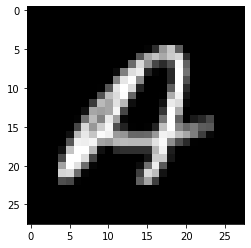

In [21]:
img = trainx[:, 108]
img = img.reshape(28, 28)
plt.imshow(img, cmap = "gray")

In [22]:
trainx = data['trainx']/255
trainy = data['trainy']
testx = data['testx']/255
testy = data['testy']

In [28]:
#use small neural network for a simple problems
#if you use larger neural network then 
d = model(trainx, trainy, testx, testy, layer_dims, 2000, 0.05, 128, True)

cost at iteration  100 :  0.04479433237617309
cost at iteration  200 :  0.03279755324368797
cost at iteration  300 :  0.02703777271128906
cost at iteration  400 :  0.02336678685237098
cost at iteration  500 :  0.020736218925935652
cost at iteration  600 :  0.018726594950645936
cost at iteration  700 :  0.0171270545312014
cost at iteration  800 :  0.015816427119028975
cost at iteration  900 :  0.014718858987888566
cost at iteration  1000 :  0.013783912948076047
cost at iteration  1100 :  0.012976472347074344
cost at iteration  1200 :  0.01227117434266175
cost at iteration  1300 :  0.011649147728753088
cost at iteration  1400 :  0.011096004923527497
cost at iteration  1500 :  0.010600552876671868
cost at iteration  1600 :  0.01015393474771043
cost at iteration  1700 :  0.009749040119470705
cost at iteration  1800 :  0.009380088656413084
cost at iteration  1900 :  0.009042329357626675
cost at iteration  2000 :  0.008731818982772099
Training accuracy:  99.95002498750625
Test accuracy:  98.

In [117]:
with open("NN_result.pickle", "wb") as pickle_out:
    pickle.dump(d, pickle_out)

In [ ]:
print(d['train_acc'])
print(d['test_acc'])

In [ ]:
with open("NN ABClassifier result", "wb") as pickle_out:
    pickle.dump(d, pickle_out)